# Major League Baseball's Billion Dollar Problem
A study of MLB pitching injuries at the NYU Stern School of Business

Written by Isaac Gammal (isaac.gammal@stern.nyu.edu)

### Background 
Since the first Tommy John surgery was performed in 1974, shoulder and elbow injuries have become priority issues for players, coaches and general managers. Recovery from shoulder and elbow soft tissue injury, particularly ulnar collateral ligament (UCL) tears and glenoid labrum tears, is often slow and greuling due to the drastic nature of surgical reconstruction and intense rehabilitation required. With 112 UCL injuries requiring reconstructive surgery in the 2015 season alone, the competitive costs, and substantial economic costs, continue to rise, prompting many to investigate risk factors associate with upper extremity injuries. Some have posited an association with rising fastball velocity, pitch counts, and pitch variability, however, due to the small sample sizes, few have found statistically significant relationships. Nevertheless, many professional and amateur organizations are taking conservative approaches to developing young pitchers, encouraging them to limit pitches counts, extend rest between starts, and delay the use of off-speed pitches.

### Purpose
In the first part of this paper, I used MLB disabled list culled by [Fangraphs](http://www.fangraphs.com/) writer [Jeff Zimmerman](http://www.baseballheatmaps.com/) and salary information provided by [Spotrac](http://www.fangraphs.com/) to compute the average length of playing time lost due to injury, and economic costs from lost salary over the past five seasons. In the second part, I used [pitchf/x](http://www.fangraphs.com/library/misc/pitch-fx/) data, a pitch tracking system created by Sportvision installed in every MLB stadium, to look at pitching characteristics leading up to an injury. 

In [37]:
'''Data were imported from referenced sources and stored locally'''

import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 
import statsmodels.formula.api as smf

%matplotlib inline    

file1 = '/Users/isaacgammal/Desktop/Sports data/pitchers.xlsx'
df1 = pd.read_excel(file1, usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]) #injured pitchers and salaries


file2 = '/Users/isaacgammal/Downloads/fx.xlsx' #pitchf/x data for injured and healthy pitchers
df2 = fx = pd.read_excel(file2)

In [38]:
df1.head()

,Name,DL type,Season,Team,Position,Position type,Location,Injury,Side,Start date,End Date,Days on DL,Salary,Injury cost
0,A.J. Burnett,15-day,2015,Pirates,RHP,P,elbow,inflammation,right,2015-07-31 00:00:00,2015-09-10 00:00:00,41,8500000.0,1.914835e+06
1,A.J. Griffin,60-day,2015,Athletics,RHP,P,shoulder,strain,right,2015-09-01 00:00:00,2015-10-04 00:00:00,33,517500.0,9.383242e+04
2,Aaron Barrett,15-day,2015,Nationals,RHP,P,arm,strain,right,2015-06-12 00:00:00,2015-07-10 00:00:00,28,514200.0,7.910769e+04
3,Aaron Barrett,15-day,2015,Nationals,RHP,P,elbow,sprain,right,2015-08-06 00:00:00,2015-10-04 00:00:00,59,514200.0,1.666912e+05
4,Aaron Crow,15-day,2015,Marlins,RHP,P,elbow,sprain,right,42099,42281,182,1975000.0,1.975000e+06


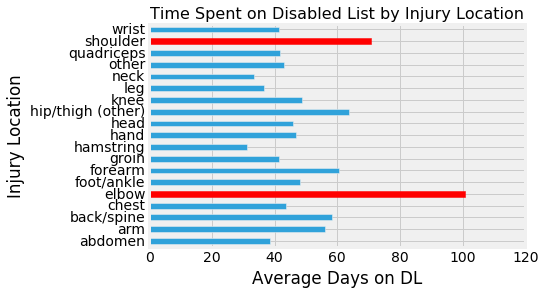

In [39]:
#compute and plot mean length of time on disabled list by season

x = df1['Days on DL'].groupby(df1['Location']).mean()

fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
x.plot(kind='barh', ax=ax, legend=False)
ax.set_title('Time Spent on Disabled List by Injury Location', fontsize=16)
ax.set_xlabel('Average Days on DL')
ax.set_ylabel('Injury Location')
ax.get_children()[4].set_color('r')
ax.get_children()[17].set_color('r')

The graph above plots average length of disability due to injury, broken down by injury location. Shoulder and elbow injuries are far and away the most devastating and common pitching injuries. The aggregate number of days spent on the DL due to UCL injury is 10,414, representing a staggering 31% of the total number of days for all elbow injuries, and 12% for all pitching injuries.

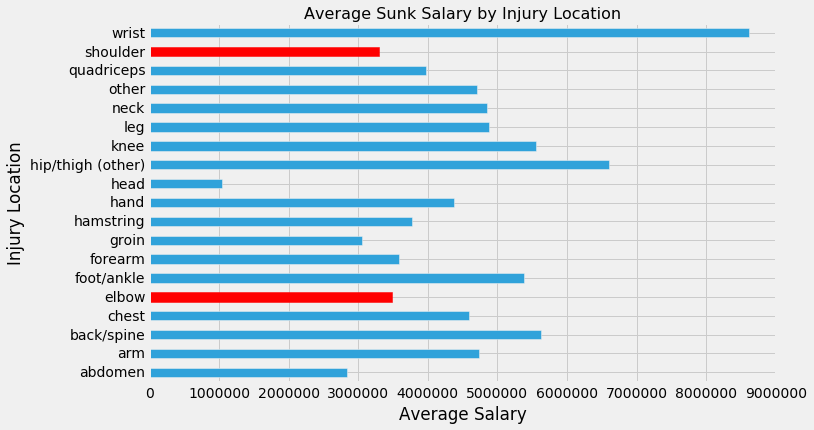

In [40]:
y = df1['Salary'].groupby(df1['Location']).mean()
fig, ax = plt.subplots(figsize=(10,6))
plt.style.use('fivethirtyeight')
y.plot(kind='barh', ax=ax, legend=False)
ax.set_title('Average Sunk Salary by Injury Location', fontsize=16)
ax.set_xlabel('Average Salary')
ax.set_ylabel('Injury Location')
ax.get_children()[4].set_color('r')
ax.get_children()[17].set_color('r')

Interestingly, despite being the most severe injuries, shoulder and elbow injuries are middle-of-the-pack in terms of lost salary (~$4,000,000). There may be several possible explanations for this finding. Perhaps pitchers with a history of these injuries are labeled as such, and then offered lower salaries in contract negotiations.  

Next I loaded the pitchf/x database and merged with the DL database. Because the databases were divided into injured and healthy pitchers, I first separated the two and then concatenated both to get a database of all pitchers. The variables in the pitchf/x database included maximum velocity (vFA), difference between maximum and minimum velocity pitch (delta), and number of unique pitches thrown (# pitches). These variables were used as predictors and regressed against innings pitched, a contnuous variable used as a proxy for injury, and scaled up for relievers vs starters.

In [56]:
fx_injured = pd.merge(df1,df2,how='left',on=['Name','Season'])
fx_healthy = pd.read_csv('/Users/isaacgammal/Downloads/healthy.csv')
fx = pd.concat([fx_injured,fx_healthy],axis=0)

In [57]:
fx.head()

,Name,DL type,Season,Team,Position,Position type,Location,Injury,Side,Start date,End Date,Days on DL,Salary,Injury cost,IP,Delta,# pitches,vFA
0,A.J. Burnett,15-day,2015,Pirates,RHP,P,elbow,inflammation,right,2015-07-31 00:00:00,2015-09-10 00:00:00,41,8500000.0,1.914835e+06,164.0,9.4,4.0,91.1
1,A.J. Griffin,60-day,2015,Athletics,RHP,P,shoulder,strain,right,2015-09-01 00:00:00,2015-10-04 00:00:00,33,517500.0,9.383242e+04,NaN,NaN,NaN,NaN
2,Aaron Barrett,15-day,2015,Nationals,RHP,P,arm,strain,right,2015-06-12 00:00:00,2015-07-10 00:00:00,28,514200.0,7.910769e+04,29.1,8.7,4.0,94.1
3,Aaron Barrett,15-day,2015,Nationals,RHP,P,elbow,sprain,right,2015-08-06 00:00:00,2015-10-04 00:00:00,59,514200.0,1.666912e+05,29.1,8.7,4.0,94.1
4,Aaron Crow,15-day,2015,Marlins,RHP,P,elbow,sprain,right,42099,42281,182,1975000.0,1.975000e+06,NaN,NaN,NaN,NaN


In [58]:
lm = smf.ols(formula='vFA ~ IP', data=fx).fit()
lm.params
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vFA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.007430
Date:                Fri, 13 May 2016   Prob (F-statistic):              0.931
Time:                        16:52:39   Log-Likelihood:                -5568.4
No. Observations:                2313   AIC:                         1.114e+04
Df Residuals:                    2311   BIC:                         1.115e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     91.3715      0.079   1156.211      0.000        91.217    91.526
IP          -8.68e-05      0.001     -0.086      0.931        -0.002     0.002
==============================================================================
Omnibus:                      148.360   Durbin-Watson:                   0.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.690
Skew:                          -0.480   Prob(JB):                     6.70e-57
Kurtosis:                       4.327   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
lm2 = smf.ols(formula='Delta ~ IP', data=fx).fit()
lm2.params
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Delta   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     94.58
Date:                Fri, 13 May 2016   Prob (F-statistic):           5.85e-22
Time:                        16:52:55   Log-Likelihood:                -6755.5
No. Observations:                2447   AIC:                         1.351e+04
Df Residuals:                    2445   BIC:                         1.353e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     11.9136      0.108    109.852      0.000        11.701    12.126
IP             0.0137      0.001      9.725      0.000         0.011     0.016
==============================================================================
Omnibus:                      346.478   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1543.344
Skew:                           0.613   Prob(JB):                         0.00
Kurtosis:                       6.693   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regressing max velocity and delta against innings pitches did not yield accurate results. The R^2 is low in both models, however, delta against innings pitches revealed a positive signifcant relationship, indicating that pitchers who vary speeds are more likely to avoid injury.

## Conclusion
Pitching injuries are widespread and contributed to nearly $1.4 billion dollars in lost salary over the past 5 seasons. Despite the ubiquity of these injuries, we are still limited in our knowledge of associated risk factors. Further work should focus on developing models to predict pitching injuries, before we can implement effective preventative measures. 